In [246]:
import numpy as np
import def_all_CRNs as CRNs
import pandas as pd
from sklearn.linear_model import LinearRegression
from dae_finder import PolyFeatureMatrix
from sklearn.preprocessing import StandardScaler
import sympy
import argparse
import itertools
from dae_finder import get_refined_lib
from dae_finder import AlgModelFinder
from dae_finder import get_simplified_equation_list
from dae_finder import construct_reduced_fit_list
from dae_finder import smooth_data
from dae_finder import add_noise_to_df
from dae_finder import solveMM


In [247]:
num_points = 1000
noise_perc = 0

clean_data = CRNs.make_CRN1(5, num_points)
clean_df = pd.DataFrame(clean_data, columns=['[t]', '[S]', '[P]', '[E]', '[ES]'])#, '[AE1]'])#, '[E2]', '[AE2]'])

data_matrix_df_list = [clean_df.iloc[i:i+num_points].reset_index(drop=True) for i in range(0, len(clean_df), num_points)]

In [248]:
tSolve = list(data_matrix_df_list[0]['[t]'])
num_time_points = len(tSolve)
noise_perc = 0

for ind, data_matrix_ in enumerate(data_matrix_df_list):
        t_exact = data_matrix_["[t]"]
        noisy_data_df = add_noise_to_df(data_matrix_, noise_perc=noise_perc, random_seed=9) # Use trial as RNG seed
        #noisy_data_df = noisy_data_df/noisy_data_df['[A]'].iloc[0]
        noisy_data_df["[t]"] = t_exact
        noisy_data_df["[S_0]"] = noisy_data_df["[S]"].iloc[0]
        noisy_data_df["[E_0]"] = noisy_data_df["[E]"].iloc[0]
        noisy_data_df["[ES_0]"] = noisy_data_df["[ES]"].iloc[0]
        #noisy_data_df["[P_0]"] = noisy_data_df["[P]"].iloc[0]
        data_matrix_df_list[ind] = noisy_data_df

data_matrix_features = data_matrix_df_list[0].columns
# 3) Smooth noisy data
num_smoothed_points = num_time_points
t_eval_new = np.linspace(data_matrix_df_list[0]["[t]"].iloc[0], data_matrix_df_list[0]["[t]"].iloc[-1], num_smoothed_points)
data_matrix_smooth_df_list = [smooth_data(data_matrix,domain_var="[t]",derr_order=1, noise_perc=noise_perc,
                                        eval_points=t_eval_new) for data_matrix in data_matrix_df_list]

if len(data_matrix_df_list) >1:
        data_matrix_df_smooth_appended = pd.concat(data_matrix_smooth_df_list, ignore_index=True)
else:
        data_matrix_df_smooth_appended = data_matrix_smooth_df_list[0]

data_matrix_df_smooth = data_matrix_df_smooth_appended[data_matrix_features]
if "[t]" in data_matrix_df_smooth:
        data_matrix_df_smooth = data_matrix_df_smooth.drop("[t]", axis=1)




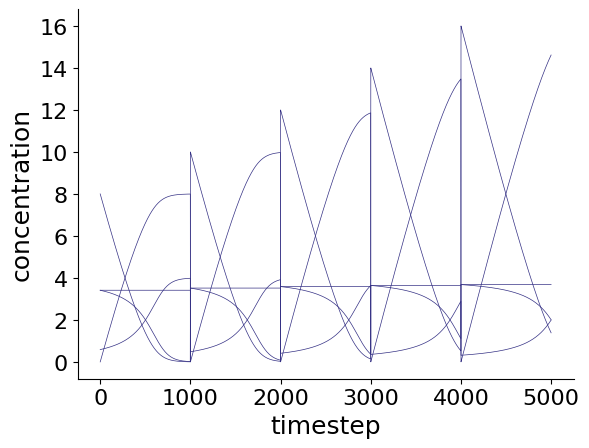

<Figure size 640x480 with 0 Axes>

In [249]:
import matplotlib.pyplot as plt

data_matrix_df_full = pd.concat(data_matrix_df_list, ignore_index=True)
fig, ax = plt.subplots()

ax.plot(data_matrix_df_full.drop(['[t]', '[S_0]', '[E_0]'], axis=1), lw=0.5, color='#343084')
plt.xlabel('timestep', fontsize=18)
plt.ylabel('concentration', fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

plt.savefig("sample.svg", bbox_inches='tight')

In [250]:
# 4) Make feature matrix, scale
clean_data = CRNs.make_CRN1(5, 100)
clean_df = pd.DataFrame(clean_data, columns=['[t]', '[S]', '[P]', '[E]', '[ES]'])

poly_degree = 2
poly_feature_ob = PolyFeatureMatrix(poly_degree)
candidate_lib_full = poly_feature_ob.fit_transform(data_matrix_df_smooth)
candidate_lib_full = candidate_lib_full.drop(["1"], axis=1)

s_scaler = StandardScaler(with_std=True, with_mean=False)
scaled_cand_lib = pd.DataFrame(s_scaler.fit_transform(candidate_lib_full), columns=s_scaler.feature_names_in_)
if '1' in scaled_cand_lib.columns:
        scaled_cand_lib['1'] = 1

feat_list = list(clean_df.columns)
feat_list += ['[S_0]']
feat_list += ['[E_0]']
feat_list += ['[ES_0]']
#feat_list += ['[P_0]']
t, S, P, E, ES, S_0, E_0, ES_0 = sympy.symbols(feat_list)

In [251]:
feat_list

['[t]', '[S]', '[P]', '[E]', '[ES]', '[S_0]', '[E_0]', '[ES_0]']

In [252]:
candidate_lib_full

,[S],[P],[E],[ES],[S_0],[E_0],[ES_0],[S]^2,[S] [P],[S] [E],...,[ES]^2,[ES] [S_0],[ES] [E_0],[ES] [ES_0],[S_0]^2,[S_0] [E_0],[S_0] [ES_0],[E_0]^2,[E_0] [ES_0],[ES_0]^2
0,8.000000,1.302097e-19,0.586667,3.413333,8.0,0.586667,3.413333,64.000000,1.041677e-18,4.693333,...,11.650844,27.306667,2.002489,11.650844,64.0,4.693333,27.306667,0.344178,2.002489,11.650844
1,7.984627,1.537300e-02,0.587630,3.412370,8.0,0.586667,3.413333,63.754268,1.227477e-01,4.692008,...,11.644267,27.298958,2.001924,11.647555,64.0,4.693333,27.306667,0.344178,2.002489,11.650844
2,7.969258,3.074178e-02,0.588597,3.411403,8.0,0.586667,3.413333,63.509077,2.449892e-01,4.690679,...,11.637672,27.291226,2.001357,11.644256,64.0,4.693333,27.306667,0.344178,2.002489,11.650844
3,7.953894,4.610622e-02,0.589566,3.410434,8.0,0.586667,3.413333,63.264426,3.667240e-01,4.689347,...,11.631059,27.283471,2.000788,11.640948,64.0,4.693333,27.306667,0.344178,2.002489,11.650844
4,7.938534,6.146634e-02,0.590538,3.409462,8.0,0.586667,3.413333,63.020317,4.879526e-01,4.688010,...,11.624428,27.275692,2.000217,11.637629,64.0,4.693333,27.306667,0.344178,2.002489,11.650844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.421951,1.457805e+01,1.966427,2.033573,16.0,0.316547,3.683453,2.021943,2.072927e+01,2.796162,...,4.135418,32.537163,0.643721,7.490570,256.0,5.064748,58.935252,0.100202,1.165985,13.567828
4996,1.412795,1.458721e+01,1.972886,2.027114,16.0,0.316547,3.683453,1.995989,2.060873e+01,2.787282,...,4.109193,32.433831,0.641677,7.466781,256.0,5.064748,58.935252,0.100202,1.165985,13.567828
4997,1.403668,1.459633e+01,1.979366,2.020634,16.0,0.316547,3.683453,1.970283,2.048840e+01,2.778372,...,4.082962,32.330146,0.639625,7.442911,256.0,5.064748,58.935252,0.100202,1.165985,13.567828
4998,1.394570,1.460543e+01,1.985868,2.014132,16.0,0.316547,3.683453,1.944824,2.036829e+01,2.769431,...,4.056727,32.226109,0.637567,7.418960,256.0,5.064748,58.935252,0.100202,1.165985,13.567828


In [253]:
# 5) Discover conservation law 1
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False,
                                    alpha=0.1)
algebraic_model_lasso.fit(data_matrix_df_smooth.drop([], axis=1), scale_columns= True)
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()
best_models_full = algebraic_model_lasso.best_models()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=data_matrix_features,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)
best_relationship = reduced_relationship_features[0]
next_best_relationship = reduced_relationship_features[0]

if None in best_relationship:
    best_relationship.remove(None)

print(best_relationship)

['[E]', '[ES]', '[ES_0]', '[E_0]']


/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.121e+03, tolerance: 6.950e+02
  model = cd_fast.enet_coordinate_descent(


In [254]:
# 5) Discover conservation law 2
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False,
                                    alpha=0.01)

algebraic_model_lasso.fit(data_matrix_df_smooth.drop(['[E]'], axis=1), scale_columns= True)
    
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()
best_models_full = algebraic_model_lasso.best_models()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=data_matrix_features,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)
best_relationship = reduced_relationship_features[0]

if None in best_relationship:
    best_relationship.remove(None)

print(best_relationship)
    

['[S]', '[P]', '[S_0]']


/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.652e+00, tolerance: 3.274e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.021e+01, tolerance: 9.500e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regula

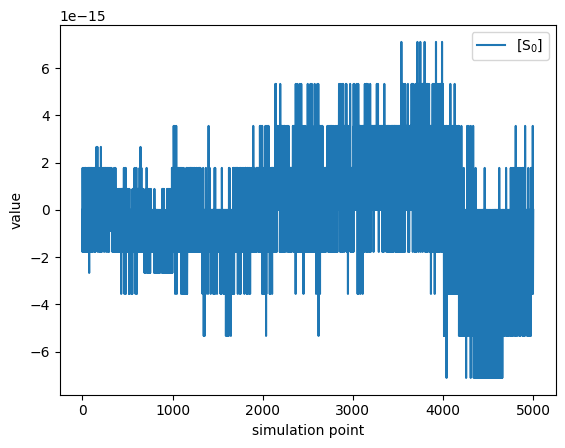

In [255]:
import matplotlib.pyplot as plt

plt.plot(data_matrix_df_smooth['[S_0]'] - (data_matrix_df_smooth['[S]'] + data_matrix_df_smooth['[P]']), label = '[S$_0$]')
plt.xlabel('simulation point')
plt.ylabel('value')
plt.legend()

In [245]:
clean_df['[S_0]'] = data_matrix_df_smooth['[S_0]']
clean_df['[ES_0]'] = data_matrix_df_smooth['[ES_0]']
clean_df['[E_0]'] = data_matrix_df_smooth['[E_0]']

_, refined_candid_lib = get_refined_lib({E, P}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

In [230]:
# 8) Discover first QSSA 
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.3)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)
best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[AE2]', '[AE1]', '[AE1] [AE2]'}):
    print(False)
else:
    print(best_models_full.iloc[-1,0])

/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.060e+01, tolerance: 9.500e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.374e+00, tolerance: 2.045e+00
  model = cd_fast.enet_coordinate_descent(


***Warning: exception occured while trying to find the monomials of 0.601067170479634:  Cannot initialize from 'dict' without generators
False


/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.333e+00, tolerance: 2.983e+00
  model = cd_fast.enet_coordinate_descent(


In [234]:
import pandas as pd
import numpy as np
import itertools
from sklearn.linear_model import LinearRegression

def find_all_relationships(df, output_csv="linear_relationships.csv"):
    """Find all possible linear relationships between subsets of columns in a dataframe and save to CSV.

    Args:
        df (pd.DataFrame): DataFrame where each column is a variable.
        output_csv (str): Filename to save results.

    Returns:
        pd.DataFrame: DataFrame containing equations and R² values.
    """
    results = []

    # Iterate over all possible target variables
    for target_col in df.columns:
        y = df[target_col]

        # Get all possible subsets of predictor variables
        predictors = [col for col in df.columns if col != target_col]
        
        # Iterate over all non-empty subsets of predictors
        for r in range(1, len(predictors) + 1):  # At least one predictor
            for predictor_subset in itertools.combinations(predictors, r):
                X = df[list(predictor_subset)]

                # Fit linear regression with intercept forced to zero
                model = LinearRegression(fit_intercept=False).fit(X, y)
                y_pred = model.predict(X)

                # Compute adjusted R² manually
                rss = np.sum((y - y_pred) ** 2)
                tss = np.sum(y ** 2)  # Since mean(y) ≠ 0
                r_squared = 1 - (rss / tss)

                # Format equation
                terms = [f"{coef:.3f} * {var}" for coef, var in zip(model.coef_, predictor_subset)]
                equation = f"{target_col} = {' + '.join(terms)}"

                # Store results
                results.append([target_col, predictor_subset, equation, r_squared])

    # Convert results to DataFrame and save as CSV
    results_df = pd.DataFrame(results, columns=["Target", "Predictors", "Equation", "R²"])
    results_df.to_csv(output_csv, index=False)

    return results_df

results_df = find_all_relationships(refined_candid_lib, "linear_relationships.csv")

# Print results
print(results_df)


KeyboardInterrupt: 

In [231]:
# [ES], [ES][S], [E_0][S], [ES_0][S]
best_relationship

['[ES_0]', '[ES_0]^2', '[E_0]']

In [232]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

def multi_series_relationship(series_list):
    """Compute the correlation matrix and linear relationships between multiple pandas Series with intercept forced to zero.

    Args:
        series_list (list of pd.Series): A list of pandas Series, assumed to have the same index.

    Returns:
        tuple:
            - correlation_matrix (pd.DataFrame): Pearson correlation matrix.
            - regression_equations (dict): Dictionary with target variables as keys and equations with adjusted R² values.
    """
    # Convert list of Series to a DataFrame
    df = pd.concat(series_list, axis=1).dropna()
    
    # Compute Pearson correlation matrix
    correlation_matrix = df.corr()

    # Perform multiple linear regression with intercept = 0
    regression_equations = {}
    for col in df.columns:
        X = df.drop(columns=[col])  # All other series as independent variables
        y = df[col]  # Current column as the dependent variable
        
        if X.shape[1] > 0:  # Ensure at least one predictor exists
            model = LinearRegression(fit_intercept=False).fit(X, y)
            y_pred = model.predict(X)

            # Compute adjusted R² manually
            rss = np.sum((y - y_pred) ** 2)
            tss = np.sum(y ** 2)  # Since mean(y) ≠ 0
            r_squared = 1 - (rss / tss)

            # Format the equation as a string
            equation_terms = [f"{coeff:.3f} * {var}" for coeff, var in zip(model.coef_, X.columns)]
            equation = f"{col} = {' + '.join(equation_terms)} (R² = {r_squared:.3f})"
            
            regression_equations[col] = equation

    return correlation_matrix, regression_equations


# Example usage:


correlation_matrix, equations = multi_series_relationship([refined_candid_lib[i] for i in best_relationship])

print("Correlation Matrix:\n", correlation_matrix)
print("\nRegression Equations:")
for target, equation in equations.items():
    print(equation)



Correlation Matrix:
             [ES_0]  [ES_0]^2     [E_0]
[ES_0]    1.000000  0.999938 -1.000000
[ES_0]^2  0.999938  1.000000 -0.999938
[E_0]    -1.000000 -0.999938  1.000000

Regression Equations:
[ES_0] = 0.253 * [ES_0]^2 + 0.796 * [E_0] (R² = 1.000)
[ES_0]^2 = 3.951 * [ES_0] + -3.143 * [E_0] (R² = 1.000)
[E_0] = 1.257 * [ES_0] + -0.318 * [ES_0]^2 (R² = 1.000)


In [106]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.1)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[AE1]', '[AE1]^2', '[AE2]^2', '[AE2]'}):
    print(False)
else:
    print(best_models_full.iloc[-1,0])


***Warning: exception occured while trying to find the monomials of 3.49768236765089:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
0.9929730774798693


/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+00, tolerance: 6.385e-01
  model = cd_fast.enet_coordinate_descent(


In [107]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[AE1]', '[A]', '[A] [AE2]'}):
    print(False)
else:
    print(best_models_full.iloc[-1,0])

***Warning: exception occured while trying to find the monomials of 3.49768236765089:  Cannot initialize from 'dict' without generators
***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
0.9923282896925675


/opt/anaconda3/envs/opt_env/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.129e+00, tolerance: 6.385e-01
  model = cd_fast.enet_coordinate_descent(


In [108]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2, A*AE2}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[AE1]', '[A]', '[A] [AE1]'}):
    print(False)
else:
    print(best_models_full.iloc[-1,0])


***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
0.9921596408994385


In [109]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2, A*AE2, A*AE1}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[AE1]', '[AE2]^2', '[AE2]', 'intercept'}):
    print(False)
else:
    print(best_models_full.iloc[-1,0])


***Warning: exception occured while trying to find the monomials of 1:  Cannot initialize from 'dict' without generators
0.9900716471094204


In [110]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2, A*AE2, A*AE1, AE2**2}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[A]', '[AE1]', '[A]^2', 'intercept'}):
    print(False)
else:
    print(best_models_full.iloc[-1,0])


0.9791038991956046


In [111]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2, A*AE2, A*AE1, AE2**2, A**2}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[AE1]', '[AE2]', '[A]'}):
    print(False)
else:
    print(best_models_full.iloc[-1,0])


0.9752060992118377


In [112]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2, A*AE2, A*AE1, AE2**2, A**2, AE2}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[AE1]', '[B] [AE1]', '[A]', 'intercept'}):
    print(False)
else:
    print(best_models_full.iloc[-1,0])


0.8818121305751268


In [73]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2, A*AE2, A*AE1, AE2**2, A**2, AE2, B*AE1}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[B]^2', '[AE1]', '[B]', 'intercept'}):
    print(False)


In [77]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2, A*AE2, A*AE1, AE2**2, A**2, AE2, B*AE1, B**2}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[AE1]', '[A] [B]', '[A]', 'intercept'}):
    print(False)


In [83]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2, A*AE2, A*AE1, AE2**2, A**2, AE2, B*AE1, B**2, A*B}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[A]', '[AE1]', 'intercept'}):
    print(False)


In [88]:
# 10) Refine library
_, refined_candid_lib = get_refined_lib({E1, E2, C, A_0, AE2*AE1, AE1**2, A*AE2, A*AE1, AE2**2, A**2, AE2, B*AE1, B**2, A*B, AE1}, clean_df,
                                                candidate_lib_full, get_dropped_feat=True)

# 11) Discover second QSSA
algebraic_model_lasso = AlgModelFinder(model_id='lasso',
                                    fit_intercept=False, alpha=0.10)
algebraic_model_lasso.fit(refined_candid_lib, scale_columns= True)
best_models_full = algebraic_model_lasso.best_models()
intercept_dictionary = algebraic_model_lasso.get_fitted_intercepts()

simplified_equations = get_simplified_equation_list(best_model_df=best_models_full.fillna(0)[:-1],
                            coef_threshold=0.05,
                            intercept_threshold= 0.01,
                            global_feature_list=clean_df.columns,
                            intercept_dict= intercept_dictionary,
                            simplified = True)
reduced_relationship_features = construct_reduced_fit_list(best_models_full.fillna(0)[:-1], simplified_eqs=simplified_equations)

best_relationship = reduced_relationship_features[0]
if None in best_relationship:
    best_relationship.remove(None)
    
lin_model = LinearRegression()

best_relation_lhs = best_relationship[0]
best_relation_rhs = best_relationship[1:]
lin_model.fit(candidate_lib_full[best_relation_rhs], candidate_lib_full[best_relation_lhs])
d = dict(zip(lin_model.feature_names_in_, lin_model.coef_))
d['intercept'] = lin_model.intercept_
d[best_relationship[0]] = np.inf # Placehold for LHS

d_filt = {k: v for k, v in d.items() if np.abs(v) >= 0.05} # keep large elements
if d['intercept'] >= 0.01: # keep large intercept
    d_filt['intercept'] = d['intercept']

# 9) Did we get it right?
if frozenset(d_filt) != frozenset({'[A]', '[B]', 'intercept'}):
    print(False)
